In [1]:
# basics + plotting
import os, sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 250
plt.rcParams["font.family"] = "sans serif"

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

# custom
PROJECT_PATH = '/n/groups/marks/databases/ukbiobank/users/ralphest/mit6.8610-project'
sys.path.insert(1, PROJECT_PATH)

from utils import (
    data_utils, 
    eval_utils, 
    plotting_utils, 
    train_test_utils,
    constants
)

from models import (
    mlp
)

import importlib
mlp = importlib.reload(mlp)
data_utils = importlib.reload(data_utils)
eval_utils = importlib.reload(eval_utils)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [23]:
data = data_utils.load_variation_dataset("../data/data/", 
                                         "../gene_list.txt", 
                                         ["esm-scores"], 
                                         "../data/phenotypes_hcm_only.parquet",
                                         predict = ["hcm"], low_memory=False, keep_genes_separate=False)

Fetching FHL1 data ... Done
Fetching ACTC1 data ... Done
Fetching ACTN2 data ... Done
Fetching CSRP3 data ... Done
Fetching MYBPC3 data ... Done
Fetching MYH6 data ... Done
Fetching MYH7 data ... Done
Fetching MYL2 data ... Done
Fetching MYL3 data ... Done
Fetching MYOZ2 data ... Done
Fetching LDB3 data ... Done
Fetching TCAP data ... Done
Fetching TNNC1 data ... Done
Fetching TNNI3 data ... Done
Fetching TNNT2 data ... Done
Fetching TPM1 data ... Done
Fetching TRIM63 data ... Done
Fetching PLN data ... Done
Fetching JPH2 data ... Done
Fetching FLNC data ... Done
Fetching ALPK3 data ... Done
Fetching LMNA data ... Done
Fetching NEXN data ... Done
Fetching VCL data ... Done
Fetching MYOM2 data ... Done
Fetching CASQ2 data ... Done
Fetching CAV3 data ... Done
Fetching MYLK2 data ... Done
Fetching CRYAB data ... Done
Combining tables ... Done
Integrating with phenotypes data ...Done


In [24]:
train_dataset, test_dataset = data.train_test_split(balance_on=['hcm','ethnicity'])

In [41]:
def train_epoch(model, train_loader, optimizer, loss_fn, log_every=10):
    model.train()
    total_loss = 0
    
    all_labels, all_preds = [],[]
    for i, batch in enumerate(train_loader):
        # move batch dictionary to device
        data_utils.batch_dict_to_device(batch, device)
        labels, features = batch['labels'], batch['esm-scores']
        
        # compute prediction and loss
        preds = model(features)
        loss = loss_fn(preds, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # tracking
        total_loss += loss.item()
        all_labels.append(labels.cpu())
        all_preds.append(preds.flatten().detach().cpu())
        
        # logging
        if (i % log_every == 0):
            print(f"\tBatch {i} | BCE Loss: {loss.item():.4f}")
    
    
    
    metrics = eval_utils.get_metrics(torch.cat(all_labels), 
                                     torch.cat(all_preds))
    metrics['loss'] = total_loss
    
    return metrics

def test(model, test_loader, loss_fn):
    model.eval()
    total_loss = 0
    all_labels, all_preds = [],[]
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            # move batch dictionary to device
            data_utils.batch_dict_to_device(batch, device)
            labels, features = batch['labels'], batch['esm-scores']

            # compute prediction and loss
            preds = model(features)
            loss = loss_fn(preds, labels)

            # tracking
            total_loss += loss.item()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.flatten().cpu())
    
    all_labels, all_preds = torch.cat(all_labels), torch.cat(all_preds)
    metrics = eval_utils.get_metrics(all_labels, 
                                     all_preds)
    metrics['loss'] = total_loss
    
    return metrics, all_labels, all_preds

def train(model, 
          train_dataset,
          test_dataset, 
          lr=1e-3, 
          n_epochs=10,
          batch_size=256):
    
    train_loader = DataLoader(
        dataset = train_dataset, 
        batch_size = batch_size,
        sampler = WeightedRandomSampler(train_dataset.weights('hcm', 
                                                              flatten_factor=1), 
                                        num_samples = len(train_dataset)),
        num_workers=12
    )

    test_loader = DataLoader(
        dataset = test_dataset,
        batch_size = batch_size,
        num_workers=12
    )
    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    track_metrics = {'train':{i:None for i in range(n_epochs)}, 
                     'test': {i:None for i in range(n_epochs)}}
    
    for epoch in range(n_epochs):
        print(f"Epoch #{epoch}:")
        train_metrics = train_epoch(model, 
                                    train_loader, 
                                    optimizer, 
                                    loss_fn, 
                                    log_every=20)
        print("Train metrics:")
        eval_utils.print_metrics(train_metrics)
        test_metrics, _, _ = test(model, 
                            test_loader, 
                            loss_fn)
        print("Test metrics:")
        eval_utils.print_metrics(test_metrics)
        
        track_metrics['train'][epoch] = train_metrics
        track_metrics['test'][epoch] = test_metrics
    
    return track_metrics
    

In [42]:
batch_size = 256
train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = batch_size,
    sampler = WeightedRandomSampler(train_dataset.weights('hcm',flatten_factor=0.5), num_samples = len(train_dataset)),
    num_workers=12
)
    
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=12
)

In [43]:
mlp_params = {
    'in_dim': 29 * 8,
    'hidden_dims': [128, 64],
    'out_dim':1,
    'actn': 'gelu'
}
model = mlp.MLP(**mlp_params)

In [44]:
model

MLP(
  (fc): Sequential(
    (0): Linear(in_features=232, out_features=128, bias=True)
    (1): GELU(approximate=none)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): GELU(approximate=none)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [45]:
metrics = train(model, 
      train_dataset,
      test_dataset, 
      lr=1e-3, 
      n_epochs=10,
      batch_size=256)

Epoch #0:
	Batch 0 | BCE Loss: 0.7013
	Batch 20 | BCE Loss: 0.6789
	Batch 40 | BCE Loss: 0.6783
	Batch 60 | BCE Loss: 0.6637
	Batch 80 | BCE Loss: 0.6582
	Batch 100 | BCE Loss: 0.6875
	Batch 120 | BCE Loss: 0.6223
	Batch 140 | BCE Loss: 0.6249
	Batch 160 | BCE Loss: 0.5935
	Batch 180 | BCE Loss: 0.6028
	Batch 200 | BCE Loss: 0.5519
	Batch 220 | BCE Loss: 0.6242
	Batch 240 | BCE Loss: 0.5510
	Batch 260 | BCE Loss: 0.5322
	Batch 280 | BCE Loss: 0.5719
	Batch 300 | BCE Loss: 0.4835
	Batch 320 | BCE Loss: 0.4945
	Batch 340 | BCE Loss: 0.5156
	Batch 360 | BCE Loss: 0.4659
	Batch 380 | BCE Loss: 0.5120
	Batch 400 | BCE Loss: 0.4349
	Batch 420 | BCE Loss: 0.4224
	Batch 440 | BCE Loss: 0.4468
	Batch 460 | BCE Loss: 0.4577
	Batch 480 | BCE Loss: 0.4543
	Batch 500 | BCE Loss: 0.3859
	Batch 520 | BCE Loss: 0.3843
	Batch 540 | BCE Loss: 0.4105
	Batch 560 | BCE Loss: 0.4214
	Batch 580 | BCE Loss: 0.4032
	Batch 600 | BCE Loss: 0.3459
	Batch 620 | BCE Loss: 0.4145
	Batch 640 | BCE Loss: 0.4066
	Batch

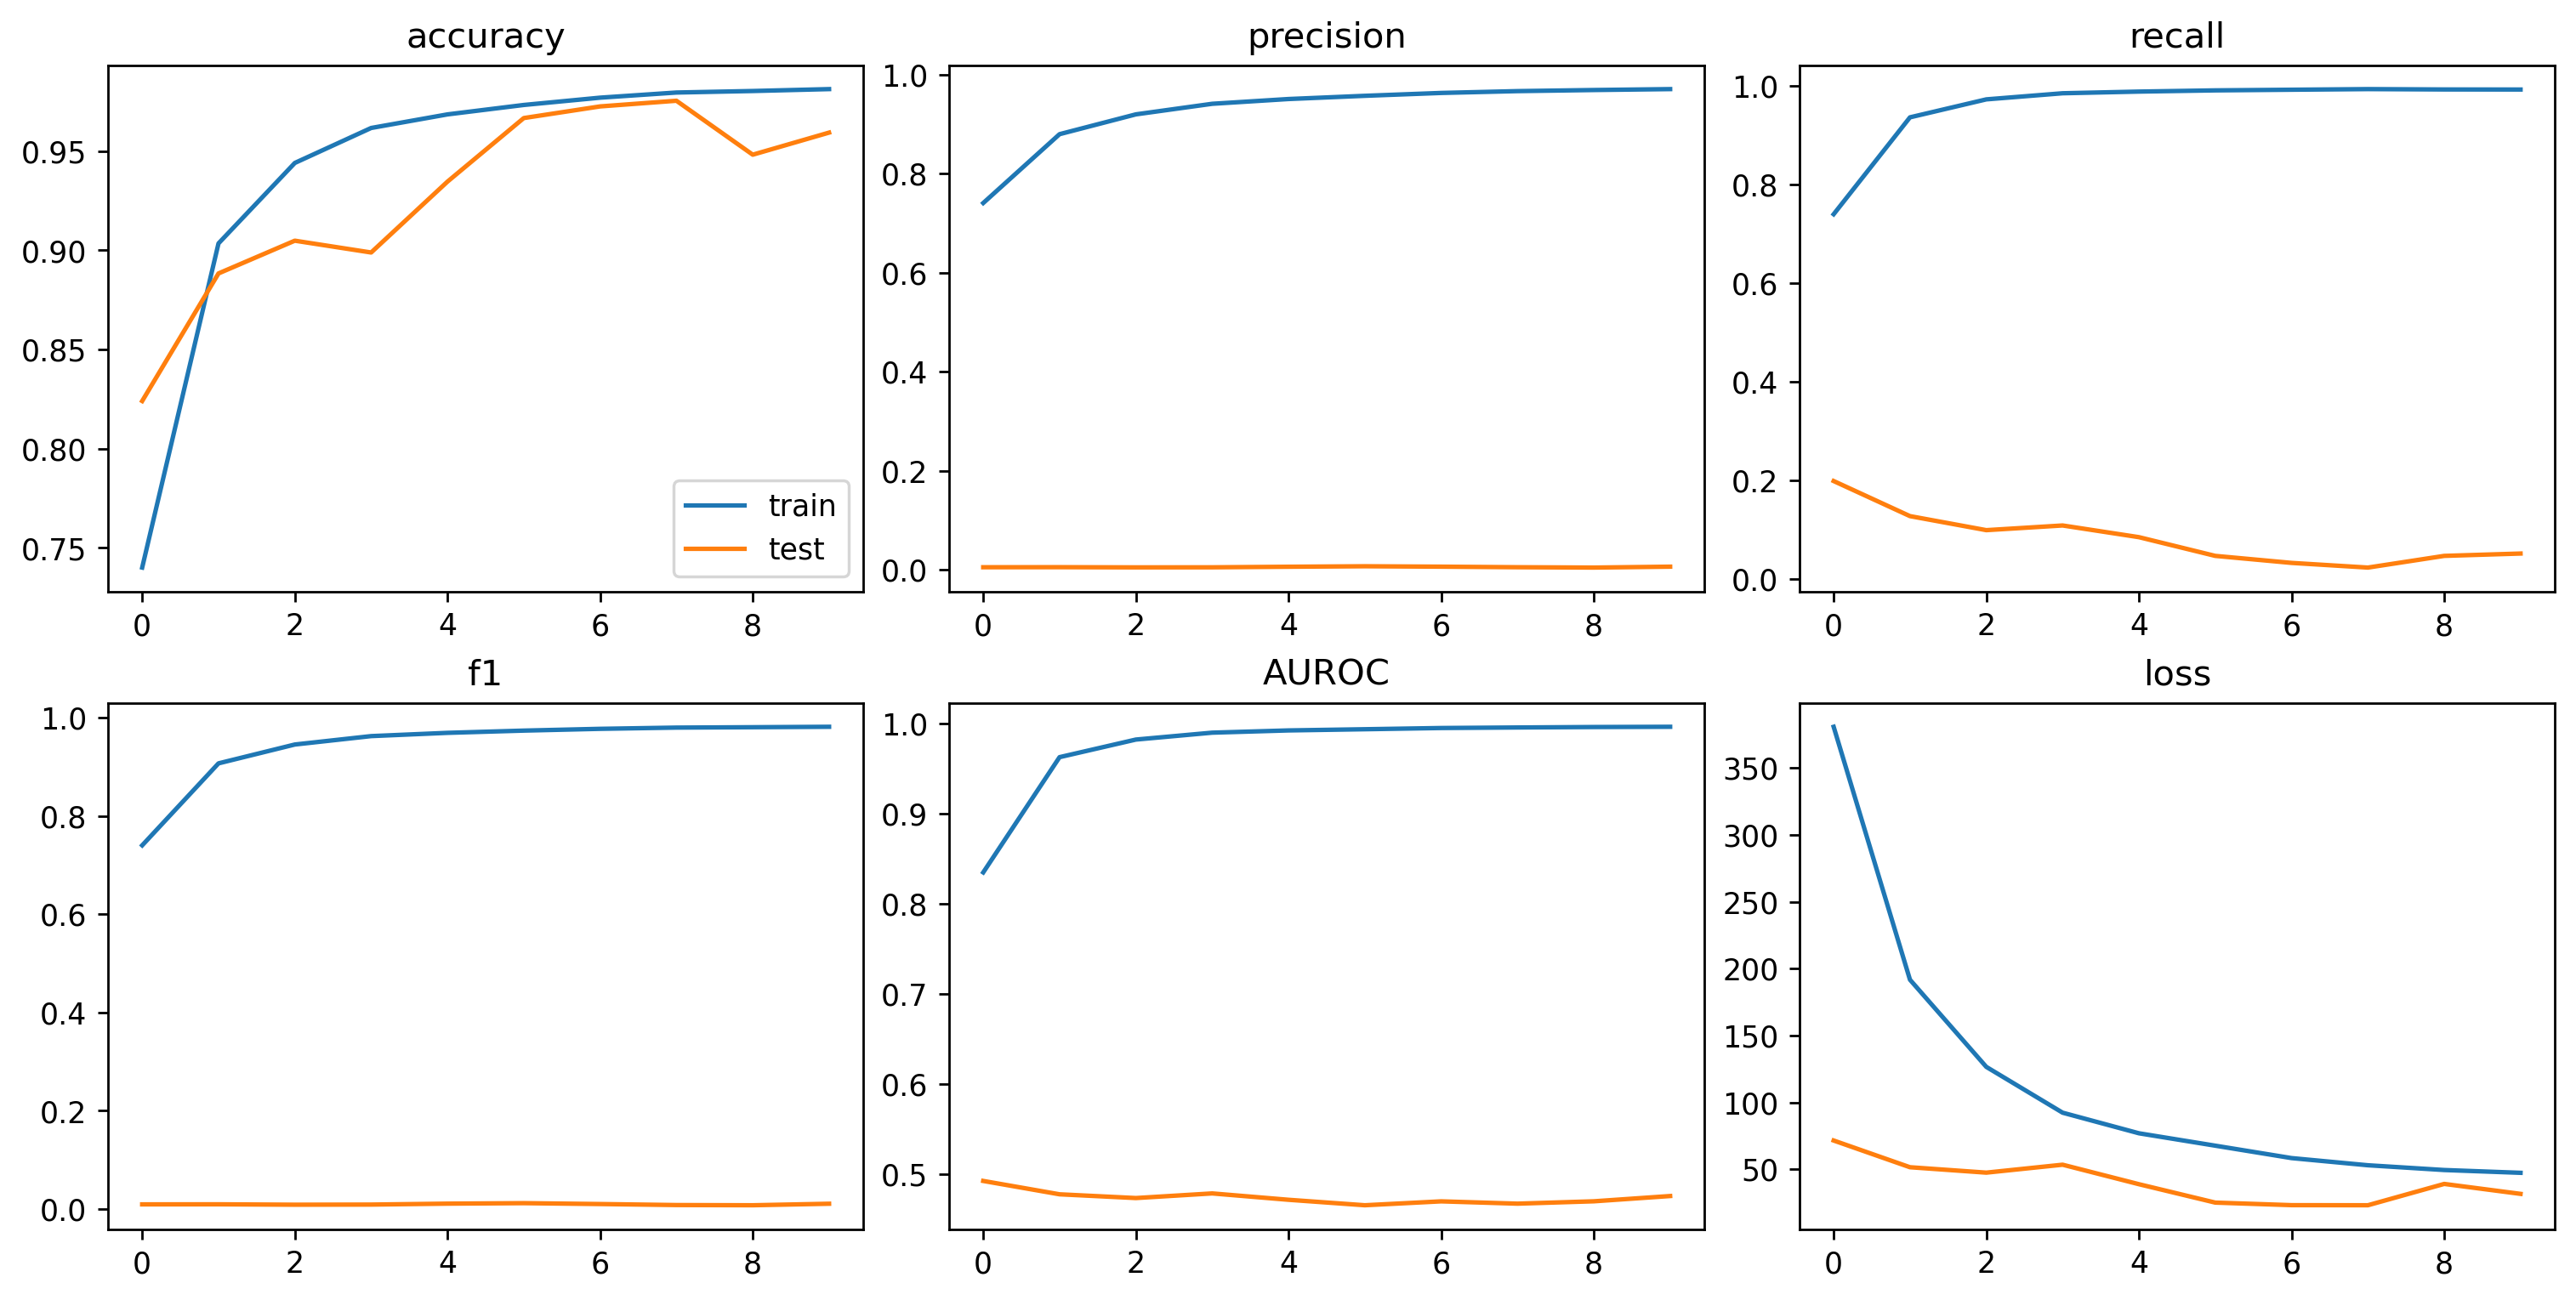

In [48]:
def plot_metrics(results, axes, metrics = ['accuracy', 'precision', 'recall', 'f1', 'AUROC', 'loss']):
    for mt,ax in zip(metrics, axes.flatten()):
        ax.plot([x[mt] for x in results['train'].values()])
        ax.plot([x[mt] for x in results['test'].values()])
        ax.set_title(mt)
    axes[0,0].legend(['train', 'test'])

fig, axes = plt.subplots(2,3,figsize=(12,6), constrained_layout=True)

plot_metrics(metrics, axes)
fig.savefig('../figures/esm-score-logreg.svg')